In [62]:
import glob
fs=glob.glob('wff/*')
fs=sorted(fs)
import numpy as np
dsdL=[]
for f in fs:
    with open(f) as fp:
        for l in fp.readlines():
            if float(l.split()[1])<60 or float(l.split()[1])>310:
                continue
            dsd_=np.array([float(v) for v in l.split()[4:]])
            dsdL.append(dsd_)

dsdL=np.array(dsdL)

In [63]:
print(dsdL.shape)
import xarray as xr
size_bins=np.arange(50)*0.2+0.1
dsd_=xr.DataArray(dsdL, dims=['time','size'], coords={'time':np.arange(dsdL.shape[0]), 'size':size_bins})
dsd_=xr.Dataset({'dsd':dsd_})
dsd_.to_netcdf('dsd_warm.nc',encoding={'dsd':{'zlib':True,'complevel':5}})

(89268, 50)


In [121]:
bin_size=np.arange(50)*0.2+0.1
rhow=1e6 # g/m3
lwc=(0.2*dsdL*(1e-3*bin_size)**3*np.pi/6*rhow).sum(axis=1)
dmL=[]
lwcL=[]
dbin=4/99
dens=np.zeros((50,500))
for dsd1 in dsdL:
    mb=0.2*dsd1*(1e-3*bin_size)**3*np.pi/6*rhow
    dmL.append(np.sum(mb*bin_size)/np.sum(mb))
    lwcL.append(np.sum(mb))
    for k,n1 in enumerate(0.2*dsd1):
        if n1<=0:
            continue
        ilog=int(n1)
        if ilog<0 or ilog>499:
            continue
        else:
            dens[k,ilog]+=1


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_50273/166580036.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(bin_size,range(500),np.log10(dens.T),cmap='jet')


(1, 1000)

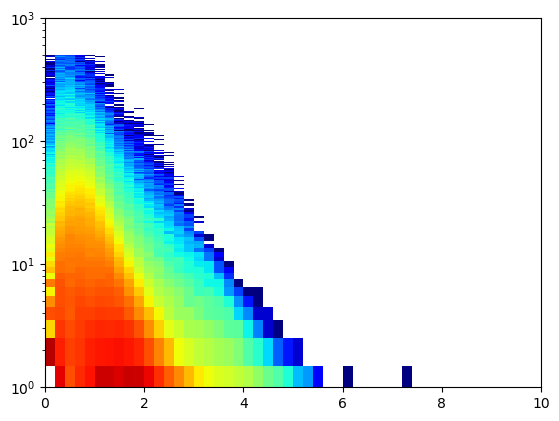

In [138]:
ybins=10**(-3+np.arange(100)*dbin)
plt.pcolormesh(bin_size,range(500),np.log10(dens.T),cmap='jet')
plt.yscale('log')
plt.ylim(1,1000)

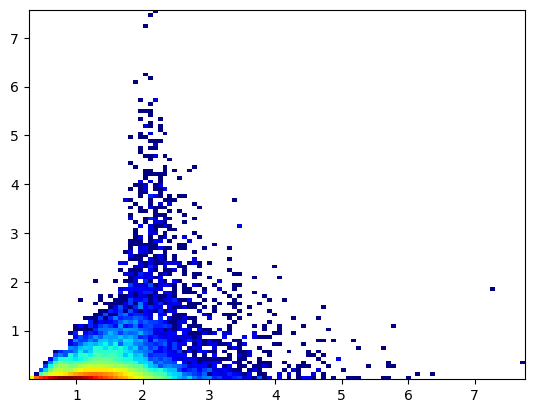

In [123]:
from matplotlib.colors import LogNorm
hdm=plt.hist2d(dmL,lwcL,bins=100,cmap='jet',norm=LogNorm())

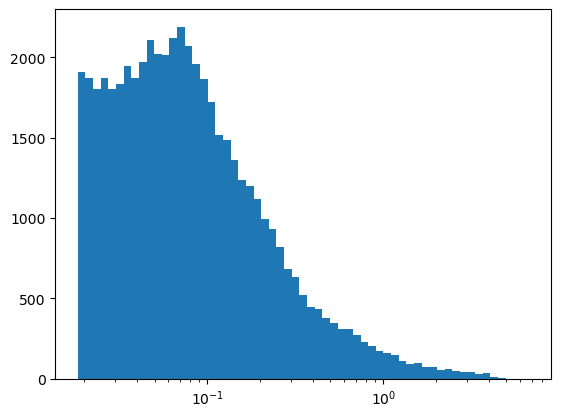

In [129]:
a=np.nonzero(np.array(lwcL)<2*np.array(dmL))
h1=plt.hist(lwc[a], bins=np.exp(-4+np.arange(60)*0.1))
plt.xscale('log')

In [127]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mass_bin=size_bins**3*dsdL*0.2
mass_bin_mean=mass_bin.mean()
mass_bin_std=mass_bin.std()
print(mass_bin_mean,mass_bin_std)
dsd_scaled=scaler.fit_transform(np.log(1+size_bins**3*dsdL[a]/mass_bin_mean)[:,:25])
pca = PCA(n_components=0.90)
pca.fit(dsd_scaled)

3.6313360388342315 23.016685426819464


PCA(n_components=0.9)

10


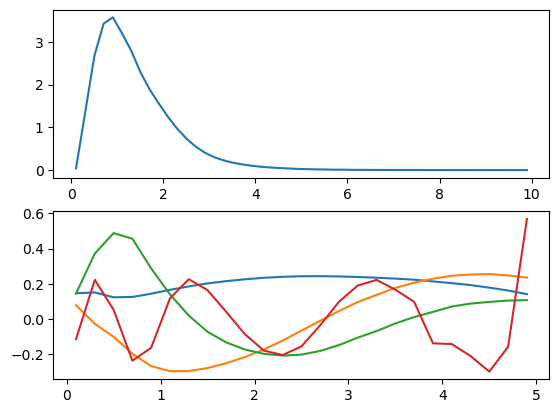

In [128]:
import matplotlib.pyplot as plt
print(pca.n_components_)
plt.subplot(211)
plt.plot(size_bins,np.log(1+size_bins**3*dsdL).mean(axis=0))
plt.subplot(212)
plt.plot(size_bins[:25],pca.components_[0])
plt.plot(size_bins[:25],pca.components_[1])
plt.plot(size_bins[:25],pca.components_[2])
plt.plot(size_bins[:25],pca.components_[7])


In [144]:

# define an autoencoder in pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

class DSDAutoEnc(nn.Module):
    def __init__(self, n_in, n_out):
        super(DSDAutoEnc, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, 25),
            nn.ReLU(True),
            nn.Linear(25, 25),
            nn.ReLU(True),
            nn.Linear(25, 12),
            nn.Dropout(0.05),
            nn.ReLU(True),
            nn.Linear(12, n_out),
            nn.BatchNorm1d(n_out),

        )
        self.decoder = nn.Sequential(
            nn.Linear(n_out, 12),
            nn.ReLU(True),
            nn.Linear(12, 25),
            nn.Dropout(0.05),
            nn.ReLU(True),
            nn.Linear(25, n_in),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
class DSDAutoEnc(nn.Module):
    def __init__(self, n_in, n_out):
        super(DSDAutoEnc, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_in, 25),
            nn.ReLU(True),
            nn.Linear(25, n_out),
            nn.BatchNorm1d(n_out),

        )
        self.decoder = nn.Sequential(
            nn.Linear(n_out, 12),
            nn.ReLU(True),
            nn.Linear(12, 25),
            nn.Dropout(0.05),
            nn.ReLU(True),
            nn.Linear(25, n_in),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [145]:
dsd_model=DSDAutoEnc(25,8)
# split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(dsd_scaled, test_size=0.2, random_state=42)
# import Dataset and DataLoader from pytorch.utils.data
from torch.utils.data import TensorDataset, DataLoader
import torch
print(X_train.shape)

training_data = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(X_train))
#test_data = Dataset(X_test, X_test)
#define the dataloader
batch_size = 64
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)


(71414, 25)


In [132]:
dsd_model_3=DSDAutoEnc(25,3)

In [147]:

# do the training
from torch import optim
# define the loss function
criterion = nn.MSELoss()
# define the optimizer
#optimizer = optim.Adam(dsd_model.parameters(), lr=0.001)
# number of epochs to train the model
n_epochs = 50
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        dsd_batch, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = dsd_model(dsd_batch)
        # calculate the loss
        loss = criterion(outputs, dsd_batch)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*dsd_batch.size(0)
    # print avg training statistics
    train_loss = train_loss/len(train_loader)
    if (epoch-1)%10==0:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch,
            train_loss
            ))

Epoch: 1 	Training Loss: 9.414583
Epoch: 11 	Training Loss: 8.925359
Epoch: 21 	Training Loss: 8.650057
Epoch: 31 	Training Loss: 8.471091
Epoch: 41 	Training Loss: 8.432678


In [134]:
from torch import optim
# define the loss function
criterion = nn.MSELoss()
# define the optimizer
optimizer_3 = optim.Adam(dsd_model_3.parameters(), lr=0.001)
# number of epochs to train the model
n_epochs = 30
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        dsd_batch, _ = data
        # clear the gradients of all optimized variables
        optimizer_3.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = dsd_model_3(dsd_batch)
        # calculate the loss
        loss = criterion(outputs, dsd_batch)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_3.step()
        # update running training loss
        train_loss += loss.item()*dsd_batch.size(0)
    # print avg training statistics
    train_loss = train_loss/len(train_loader)
    if (epoch-1)%10==0:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch,
            train_loss
            ))

Epoch: 1 	Training Loss: 26.401102
Epoch: 11 	Training Loss: 14.286315
Epoch: 21 	Training Loss: 13.919836


In [149]:
dsd_rec=dsd_model(torch.FloatTensor(X_test)).detach().numpy()
dsd_rec_3=dsd_model_3(torch.FloatTensor(X_test)).detach().numpy()

(17854, 25)


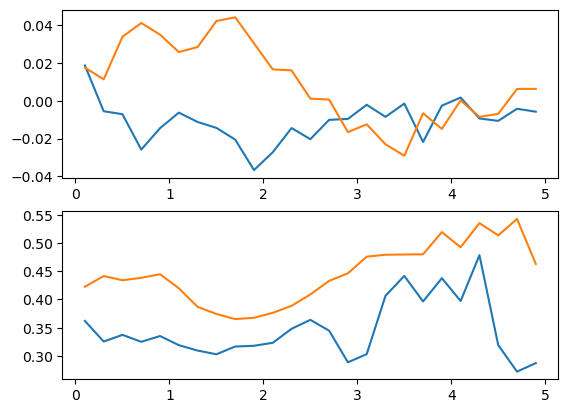

In [150]:
print(dsd_rec.shape)
plt.subplot(211)    
plt.plot(size_bins[:25],(dsd_rec-X_test).mean(axis=0))
plt.plot(size_bins[:25],(dsd_rec_3-X_test).mean(axis=0))
plt.subplot(212)
plt.plot(size_bins[:25],(dsd_rec-X_test).std(axis=0))
plt.plot(size_bins[:25],(dsd_rec_3-X_test).std(axis=0))
#plt.plot(size_bins[:25],X_test.std(axis=0))